# Convolutional Neural Network - MNIST

Make Your First GAN With MindSpore, 2022

In [1]:
# import libraries

import mindspore
import mindspore.nn as nn
from torch.utils.data import Dataset

import pandas
import numpy
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Cell):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def construct(self, x):
        return x.view(*self.shape)


## DataSet Class

In [3]:
# dataset class

class MnistDataset:
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = numpy.zeros((10), dtype=numpy.float32)
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = numpy.array(self.data_df.iloc[index,1:].values, dtype=numpy.float32) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')


## Load Data

In [4]:
mnist_dataset = MnistDataset('./dataset/mnist/mnist_train.csv')

batch_size = 1
train_dataset = mindspore.dataset.GeneratorDataset(mnist_dataset, ['label', 'image', 'target']).batch(batch_size)

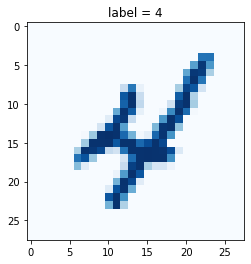

In [5]:
# check data contains images

mnist_dataset.plot_image(9)

## Neural Network Class

In [6]:
# classifier class

class Classifier(nn.Cell):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            # expand 1 to 10 filters
            nn.Conv2d(1, 10, kernel_size=5, stride=2, pad_mode='pad'),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
        
            # 10 filters to 10 filters
            nn.Conv2d(10, 10, kernel_size=3, stride=2, pad_mode='pad'),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            View((-1, 250)),
            nn.Dense(250, 10),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss(reduction='mean')

        # create optimizer
        self.optimizer = nn.Adam(self.model.trainable_params())

        self.model_with_loss = nn.WithLossCell(self.model, self.loss_function)
        self.model_train = nn.TrainOneStepCell(self.model_with_loss, self.optimizer)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

    def construct(self, inputs):
        if inputs.ndim == 3:
            inputs = mindspore.ops.ExpandDims()(inputs, 0)
            return self.model(inputs).squeeze(0)
        else:
            return self.model(inputs)

    def train(self, inputs, targets):
        # train one step
        loss = self.model_train(inputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.asnumpy().item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


## Train Neural Network

In [7]:
%%time 
# create neural network

C = Classifier()

# train network on MNIST data set

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in train_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)


training epoch 1 of 3


[WARNING] DEVICE(52447,ffffb4915a40,python3.7):2022-05-24-23:49:31.493.043 [mindspore/ccsrc/runtime/hardware/ascend/ascend_graph_optimization.cc:259] SelectKernel] There are 5 node/nodes used reduce precision to selected the kernel!


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 8min 52s, sys: 1min 55s, total: 10min 48s
Wall time: 7min 28s


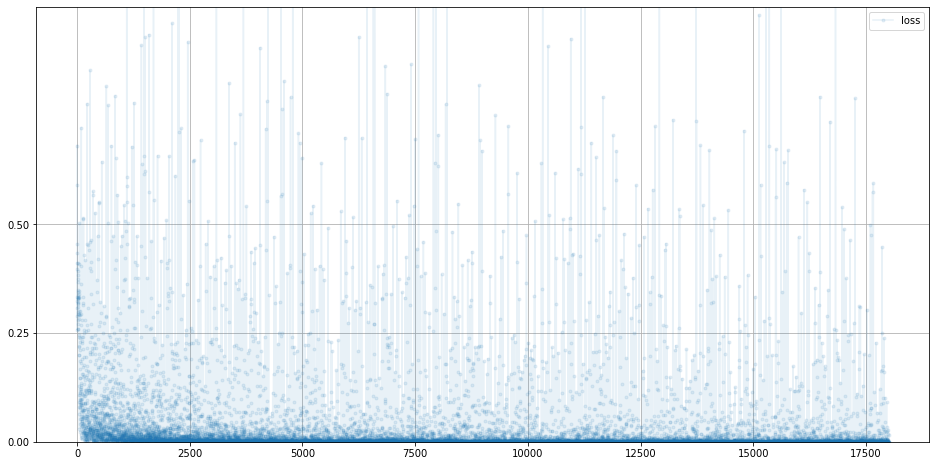

In [8]:
# plot classifier error

C.plot_progress()

## Classification Example

In [9]:
# load MNIST test data

mnist_test_dataset = MnistDataset('./dataset/mnist/mnist_test.csv')

batch_size = 1
test_dataset = mindspore.dataset.GeneratorDataset(mnist_test_dataset, ['label', 'image', 'target']).batch(batch_size)

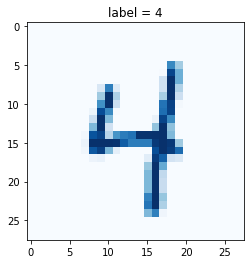

In [10]:
# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

[WARNING] DEVICE(52447,ffffb4915a40,python3.7):2022-05-24-23:56:48.974.855 [mindspore/ccsrc/runtime/hardware/ascend/ascend_graph_optimization.cc:259] SelectKernel] There are 2 node/nodes used reduce precision to selected the kernel!


<AxesSubplot:>

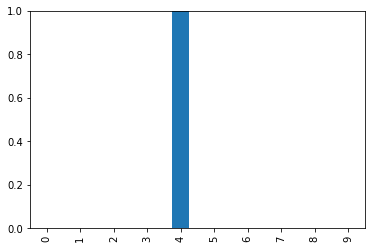

In [11]:
# visualise the answer given by the neural network

image_data = mindspore.Tensor(mnist_test_dataset[record][1])

# query from trained network
output = C.construct(image_data.view(1,1,28,28))

# plot output tensor
pandas.DataFrame(output[0].asnumpy()).plot(kind='bar', legend=False, ylim=(0,1))

## Classifier Performance

In [ ]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, _ in test_dataset:
    answer = C.construct(image_data_tensor.view(1,1,28,28))[0].asnumpy()
    if (answer.argmax() == label[0].asnumpy().item()):
        score += 1
    items += 1

print(score, items, score/items)

[WARNING] DEVICE(52447,ffffb4915a40,python3.7):2022-05-24-23:56:53.383.452 [mindspore/ccsrc/runtime/device/ascend/kernel_select_ascend.cc:327] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[StridedSlice] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(52447,ffffb4915a40,python3.7):2022-05-24-23:56:53.383.525 [mindspore/ccsrc/runtime/hardware/ascend/ascend_graph_optimization.cc:259] SelectKernel] There are 1 node/nodes used reduce precision to selected the kernel!
